# Amnesiac Unlearning

## Remarks:

### Amnesiac unlearning has been abandoned for the most part——it requires a tiny batch size to avoid perturbing too many batches, and nevertheless results in catastrophic degradation of performance after unlearning just a few epochs of batch updates. This notebook has thus been archived for educational purposes.
### This notebook also contains code below for generating membership inference attacks (MIA) and model inversion (MI) attacks, independent of the unlearning method.

# ––––––––––

In [1]:
import copy
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchinfo import summary
from torchvision import transforms
from tqdm import tqdm

In [2]:
drive = None
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
path = "./"

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path = path if drive is None else "/content/drive/MyDrive/self-learn/unlearning"

In [5]:
sys.path.append(path)

In [6]:
from constants import *
from utils import (
    set_seed,
    train_data,
    val_data,
    train_loader,
    val_loader,
    fine_labels,
    invTrans,
)
from models import get_model_and_optimizer, get_attack_model_and_optimizer

set_seed()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
MODEL_NAME = f"CNN_CIFAR_100_ORIGINAL"
print("Model Name:", MODEL_NAME)

Model Name: CNN_CIFAR_100_ORIGINAL


# Data

In [8]:
# # (BATCH_SIZE, 3, 32, 32), picture of an apple

# batch = next(iter(train_loader))
# print(batch[0].shape)
# test_idx = 2
# plt.imshow(batch[0][test_idx].permute(1,2,0))
# plt.title(f'{fine_labels[batch[1][test_idx]]}')

# Amnesiac Training

In [9]:
target_class = 23
fine_labels[target_class]

'cloud'

## TODO: change to something else and re-train such as [20] = chair or [5] = bed

In [10]:
def amnesiac_train(model, train_loader, val_loader, optimizer, criterion, device):
    """
    Trains the specified model, returning train losses, validation losses, validation accuracies, and
    parameter updates for batches containing data of the sensitive class. Currently does not support
    multiple sensitive classes.
    """
    model.train()
    model.to(device)
    train_losses, val_losses = [], []
    val_accuracies = []
    deltas = []

    for epoch in range(EPOCHS):

        print(f"Epoch {epoch+1}/{EPOCHS}")

        delta = {}
        for name, _ in model.named_parameters():
            if "weight" in name or "bias" in name:
                delta[name] = 0

        for step, (img, label) in enumerate(train_loader):

            img, label = img.to(device), label.to(device)

            if target_class in label:
                pre = {}
                for name, param in model.named_parameters():
                    if "weight" in name or "bias" in name:
                        pre[name] = param.data.clone()

            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, label)
            train_losses.append(loss.item())  # every step
            loss.backward()

            # Monitoring overall gradient norm
            grads = [
                param.grad.detach().flatten()
                for param in model.parameters()
                if param.grad is not None
            ]
            norm = torch.cat(grads).norm()

            optimizer.step()

            if target_class in label:
                post = {}
                for name, param in model.named_parameters():
                    if "weight" in name or "bias" in name:
                        post[name] = param.data.clone()
                for key in pre:
                    delta[key] = delta[key] + (post[key] - pre[key])

            if step % PRINT_ITERS == 0 and step != 0:
                val_loss, val_acc = eval(model, val_loader, criterion, device)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                print(
                    f"Step: {step}/{len(train_loader)}, Running Average Loss: {np.mean(train_losses):.3f} |",
                    f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f} | Grad Norm: {norm:.2f}",
                )
                model.train()

        deltas.append(delta)

        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{epoch+1}_SEED_{SEED}.pt",
        )

        with open(
            f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_train_losses.json", "w"
        ) as f:
            json.dump(train_losses, f)

        with open(
            f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_losses.json", "w"
        ) as f2:
            json.dump(val_losses, f2)

        with open(
            f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_accuracies.json", "w"
        ) as f3:
            json.dump(val_accuracies, f3)

        torch.save(deltas, f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_deltas.pt")

    return train_losses, val_losses, val_accuracies, deltas

In [11]:
def eval(model, val_loader, criterion, device):
    val_losses = []
    correct = 0
    model.eval()

    with torch.no_grad():
        for i, (img, label) in enumerate(val_loader):

            img, label = img.to(device), label.to(device)
            out = model(img)

            loss_eval = criterion(out, label)
            val_losses.append(loss_eval.item())

            pred = out.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    val_loss = np.mean(val_losses)
    val_acc = correct / ((len(val_loader) - 1) * BATCH_SIZE + label.size(0))

    return val_loss, val_acc

In [38]:
model, optimizer = get_model_and_optimizer(seed=SEED)
model.to(device)
# summary(model)

# since no log-softmax output layer in model
criterion = nn.CrossEntropyLoss()

In [ ]:
## Driver code
train_losses, val_losses, val_accuracies, deltas = amnesiac_train(
    model, train_loader, val_loader, optimizer, criterion, device
)

## Loading

### TEMP: using trained model from other project (epoch 100) to test model inversion code for now
### load epoch = 100 is trained without deltas and cannot perform amnesiac unlearning.

In [13]:
# LOAD_EPOCH = 50
LOAD_EPOCH = 100

model, optimizer = get_model_and_optimizer()
model.load_state_dict(
    torch.load(
        f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{LOAD_EPOCH}_SEED_{SEED}.pt",
        map_location=device,
    )["model_state_dict"]
)
optimizer.load_state_dict(
    torch.load(
        f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{LOAD_EPOCH}_SEED_{SEED}.pt",
        map_location=device,
    )["optimizer_state_dict"]
)
model.to(device)
print("Model and optimizer loaded")

with open(f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_train_losses.json", "r") as f:
    train_losses = json.load(f)

with open(f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_losses.json", "r") as f2:
    val_losses = json.load(f2)

with open(f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_accuracies.json", "r") as f3:
    val_accuracies = json.load(f3)

deltas = torch.load(
    f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_deltas.pt", map_location=device
)

print("Losses, accuracies, deltas loaded")

criterion = nn.CrossEntropyLoss()

Model and optimizer loaded
Losses, accuracies, deltas loaded


# Verification

In [19]:
forget_idx = np.where(np.array(train_data.targets) == target_class)[0]
forget_mask = np.zeros(len(train_data.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

forget_data = torch.utils.data.Subset(train_data, forget_idx)
retain_data = torch.utils.data.Subset(train_data, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_data, batch_size=BATCH_SIZE, shuffle=False
)
retain_loader = torch.utils.data.DataLoader(
    retain_data, batch_size=BATCH_SIZE, shuffle=False
)

In [45]:
## Accuracy on validation data
eval(model, val_loader, criterion, device)[1]  # val data

0.4575

In [44]:
## Accuracy on train_data of only the target class to forget
eval(model, forget_loader, criterion, device)[1]  # forget data from train

0.8214285714285714

# Unlearn

In [18]:
def unlearn_last_k_epochs(model, deltas, k):
    for delta in deltas[-k:]:
        with torch.no_grad():
            state = model.state_dict()
            for name, param in model.named_parameters():
                if "weight" in name or "bias" in name:
                    state[name] = state[name] - delta[name]
            model.load_state_dict(state)

Interestingly, we cannot revert all the parameter updates——this leads to a catastrophic degradation in performance back to that of a randomly initialized model. Instead, we revert only the last epoch.

We see that the model becomes completely unable to accurately predict the target_class—perhaps suspiciously too inept, which could be a different problem.

This leads to a ~1% drop in validation performance. A second epoch would drop a further 8%.

In [119]:
unlearn_last_k_epochs(model, deltas, 1)

In [65]:
eval(model, val_loader, criterion, device)[1]

0.4441

In [120]:
eval(model, forget_loader, criterion, device)[1]

0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


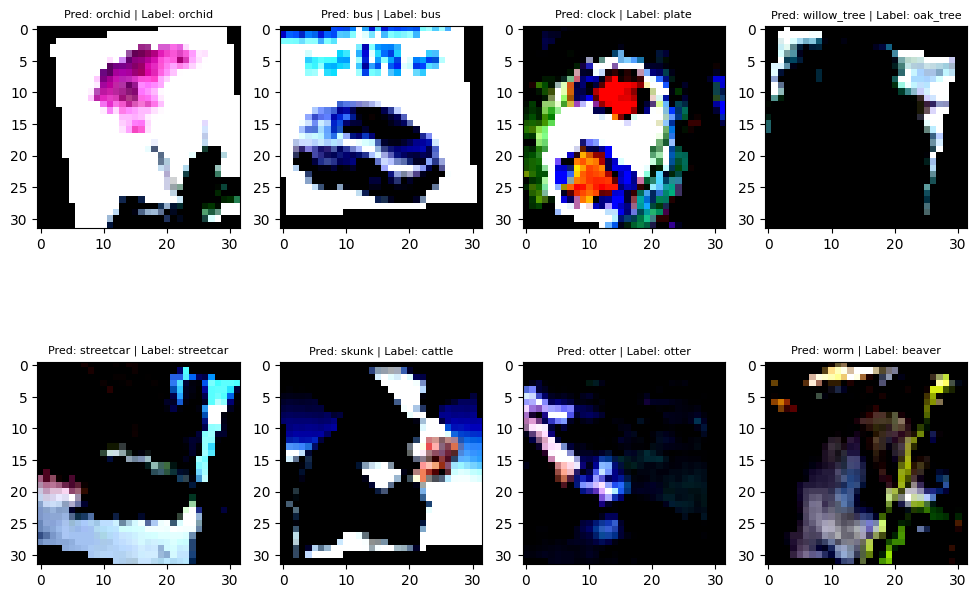

In [159]:
unlearn_val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=BATCH_SIZE, shuffle=True
)

model.eval()
with torch.no_grad():
    for i, (img, label) in enumerate(unlearn_val_loader):
        img, label = img.to(device), label.to(device)
        out = model(img)
        pred = out.argmax(dim=1, keepdim=True)
        break

fig, axes = plt.subplots(2, 4, figsize=(12, 8))
for i, ax in enumerate(axes.ravel()):
    ax.set_title(
        f"Pred: {fine_labels[pred[i]]} | Label: {fine_labels[label[i]]}", fontsize=8
    )
    ax.imshow(img[i].cpu().permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


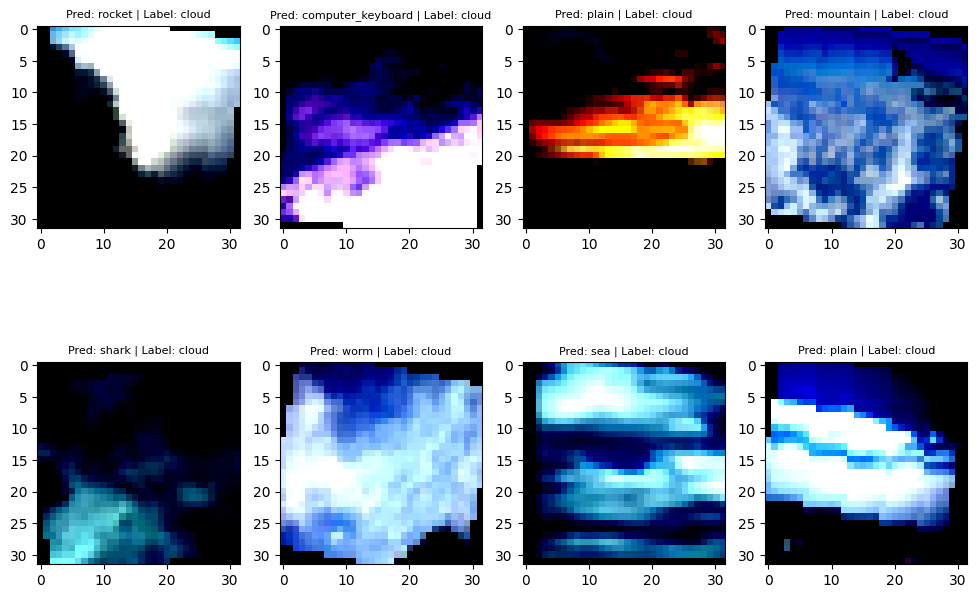

In [160]:
model.eval()
with torch.no_grad():
    for i, (img, label) in enumerate(forget_loader):
        img, label = img.to(device), label.to(device)
        out = model(img)
        pred = out.argmax(dim=1, keepdim=True)
        break

fig, axes = plt.subplots(2, 4, figsize=(12, 8))
for i, ax in enumerate(axes.ravel()):
    ax.set_title(
        f"Pred: {fine_labels[pred[i]]} | Label: {fine_labels[label[i]]}", fontsize=8
    )
    ax.imshow(img[i].cpu().permute(1, 2, 0))
plt.show()

## i) Membership inference

In [21]:
shadow_models = [get_model() for _ in range(NUM_SHADOW_MODELS)]
shadow_data = [
    torch.utils.data.random_split(
        train_data, [int(len(train_data) / 2), int(len(train_data) / 2)]
    )
    for _ in range(NUM_SHADOW_MODELS)
]
# in our case we simply use the same train data as that of the target model with a 50/50 split

In [22]:
def shadow_train(model, optimizer, loader, criterion):
    model.train()
    train_losses = []

    for epoch in range(SHADOW_EPOCHS):
        print(f"Epoch {epoch+1}/{SHADOW_EPOCHS}")

        for step, (img, label) in enumerate(loader):

            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, label)
            train_losses.append(loss.item())  # every step
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch+1}, Running Average Loss: {np.mean(train_losses):.3f}")

In [ ]:
# Train shadow models
for i, (model, optim) in enumerate(shadow_models):
    in_loader = torch.utils.data.DataLoader(
        shadow_data[i][0], batch_size=BATCH_SIZE, shuffle=True
    )
    print(f"Training shadow model {i}")
    shadow_train(model, optim, in_loader, criterion)

In [32]:
def prep_attack_data(shadow_models, shadow_data, target_class):

    attack_inputs, attack_labels = [], []
    for i, (model, optim) in enumerate(shadow_models):
        in_loader = torch.utils.data.DataLoader(shadow_data[i][0], batch_size=1)
        for (img, label) in tqdm(in_loader):
            if label == target_class:
                pred = model(img).squeeze(0)
                # append probabilities to attack input
                # given this is from in_loader, give label 1

                # # is it necessary for model to predict correctly?
                # if pred.argmax().item() == target_class:
                attack_inputs.append(nn.Softmax(pred))
                attack_labels.append(1)
        out_loader = torch.utils.data.DataLoader(shadow_data[i][1], batch_size=1)
        for (img, label) in tqdm(out_loader):
            if label == target_class:
                pred = model(img).squeeze(0)
                attack_inputs.append(nn.Softmax(pred))
                attack_labels.append(0)

    attack_data = torch.utils.data.TensorDataset(
        torch.stack(attack_inputs), torch.Tensor(attack_labels)
    )
    attack_train, attack_test = torch.utils.data.random_split(
        attack_data[0],
        [
            int(0.9 * len(attack_datasets[0])),
            len(attack_datasets[0]) - int(0.9 * len(attack_datasets[0])),
        ],
    )

    attack_train_loader = torch.utils.data.DataLoader(
        attack_train, batch_size=BATCH_SIZE, shuffle=True
    )
    attack_test_loader = torch.utils.data.DataLoader(
        attack_test, batch_size=BATCH_SIZE, shuffle=True
    )
    return attack_train_loader, attack_test_loader


def attack_train(model, optimizer, loader):
    pass

In [ ]:
# Only one attack model here because we only remove one target class
attack_model, attack_optim = get_attack_model()
attack_train_loader, attack_test_loader = prep_attack_data(
    shadow_models, shadow_data, target_class
)
attack_train(attack_model, attack_optim, attack_train_loader)

### TODO (low priority, lots training required) test MIA on trained and unlearned model

## ii) Model inversion

In [255]:
set_seed()
inp = torch.zeros(1, 3, 32, 32).to(device)
# also tried starting with rand / ones (white).
# in all cases, this seems to learn very little dots and pieces incoherently
# using custom loss function yields similar results
inp.requires_grad = True
criterion = nn.CrossEntropyLoss()

In [256]:
from scipy import ndimage


def invert(model, inp, target_class, num_iters, lr, device, v_min=0, v_max=1):
    model.eval()
    label = torch.tensor(target_class).unsqueeze(0).to(device)
    for i in range(num_iters):
        inp = torch.clamp(inp, min=0, max=1)
        # inp.requires_grad = True
        inp.retain_grad()
        if i % 500 == 0 and i != 0:
            print(f"Iter: {i}, Loss: {loss}")

        model.zero_grad()
        pred = model(inp)
        loss = criterion(pred, label)
        # loss = 1 - F.softmax(pred[0], dim=-1)[target_class]
        loss.backward()
        inp = (inp - lr * inp.grad).clone().detach().requires_grad_(True)
        inp = torch.clamp(inp, min=0, max=1)
        # apply post-processing sometimes. transforms chosen from AmnesiacML
        #### TODO: hyperparams should likely be tweaked for better performance, but unsure how to do so without
        #### overfitting/leakage on the specific class to forget
        if i % 500 == 0 and i > 0:
            inp = ndimage.median_filter(inp.detach(), size=1)
            blur = ndimage.gaussian_filter(inp, sigma=-10)
            filter_blur = ndimage.gaussian_filter(blur, sigma=1, truncate=-1 / 2)
            inp = blur + 10 * (blur - filter_blur)
            # starting from black or white noise tends to stay at the extreme, so forced min-max scaling
            inp = (inp - inp.min()) / (inp.max() - inp.min()) * (v_max - v_min) + v_min
            inp = torch.from_numpy(inp)
            inp.requires_grad = True
    inp = torch.clamp(inp, min=0, max=1)
    return inp[0]

In [156]:
inverted_inp = invert(
    model, inp, target_class, num_iters=10000, lr=1e-3, device=device, v_min=0, v_max=1
)

Iter: 500, Loss: 0.06630648672580719
Iter: 1000, Loss: 0.05298587307333946
Iter: 1500, Loss: 0.04714663326740265
Iter: 2000, Loss: 0.0426773801445961
Iter: 2500, Loss: 0.03891962766647339
Iter: 3000, Loss: 0.03578729182481766
Iter: 3500, Loss: 0.03317445516586304
Iter: 4000, Loss: 0.030494187027215958
Iter: 4500, Loss: 0.028119705617427826
Iter: 5000, Loss: 0.026154711842536926
Iter: 5500, Loss: 0.024416102096438408
Iter: 6000, Loss: 0.022856244817376137
Iter: 6500, Loss: 0.021431760862469673
Iter: 7000, Loss: 0.020061446353793144
Iter: 7500, Loss: 0.018861347809433937
Iter: 8000, Loss: 0.01778476871550083
Iter: 8500, Loss: 0.016748880967497826
Iter: 9000, Loss: 0.01570710726082325
Iter: 9500, Loss: 0.014231733046472073


In [157]:
F.softmax(model(inverted_inp.unsqueeze(0)), dim=-1).max(dim=-1)

torch.return_types.max(
values=tensor([0.9870], grad_fn=<MaxBackward0>),
indices=tensor([23]))

Text(0.5, 1.0, 'Model Inversion for cloud')

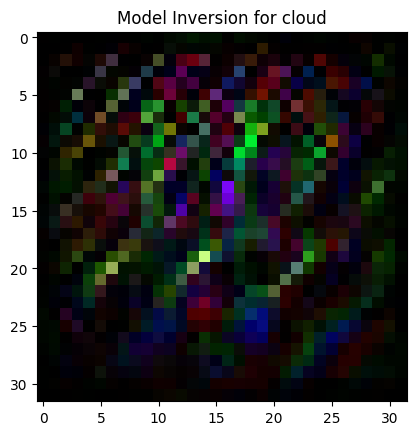

In [153]:
plt.imshow(inverted_inp.permute(1, 2, 0).cpu().detach().numpy())
plt.title(f"Model Inversion for {fine_labels[target_class]}")

Text(0.5, 1.0, 'Model Inversion for bed')

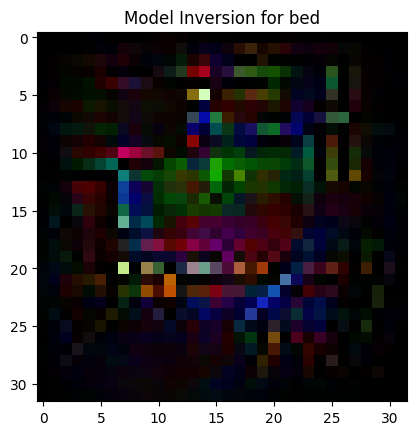

In [171]:
## archived output
# plt.imshow(inverted_inp.permute(1,2,0).cpu().detach().numpy())
# plt.title(f'Model Inversion for {fine_labels[5]}')

## maybe I'm delusional but I can kinda see the red splotch as the bed and the diagonal lines surrounding it as the frame

Text(0.5, 1.0, 'Model Inversion for chair')

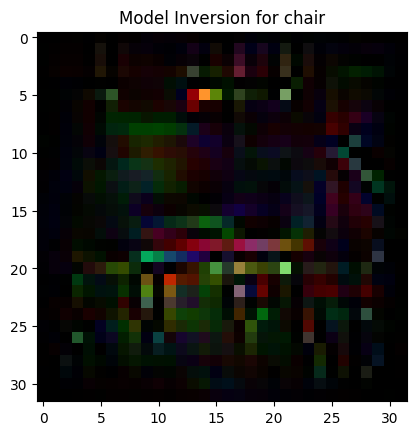

In [260]:
## archived output
# plt.imshow(inverted_inp.permute(1,2,0).cpu().detach().numpy())
# plt.title(f'Model Inversion for {fine_labels[20]}')

## same here——I feel like I can see the base of the chair with that red horizontal line and then two vertical lines
# below it...just need better processing fns / hyperparams maybe

In [226]:
inverted_inp = invert(
    model, inp, target_class, num_iters=10000, lr=1e-3, device=device, v_min=0, v_max=1
)

Iter: 500, Loss: 0.06627859175205231
Iter: 1000, Loss: 0.6770790815353394
Iter: 1500, Loss: 0.2322024554014206
Iter: 2000, Loss: 0.1500236988067627
Iter: 2500, Loss: 0.11929082125425339
Iter: 3000, Loss: 0.10101841390132904
Iter: 3500, Loss: 0.08909714967012405
Iter: 4000, Loss: 0.08023661375045776
Iter: 4500, Loss: 0.07337329536676407
Iter: 5000, Loss: 0.06768286973237991
Iter: 5500, Loss: 0.0629100427031517
Iter: 6000, Loss: 0.058849774301052094
Iter: 6500, Loss: 0.05563265457749367
Iter: 7000, Loss: 0.05290989577770233
Iter: 7500, Loss: 0.0504770390689373
Iter: 8000, Loss: 0.04827341064810753
Iter: 8500, Loss: 0.04626309871673584
Iter: 9000, Loss: 0.044345442205667496
Iter: 9500, Loss: 0.042653393000364304


In [227]:
F.softmax(model(inverted_inp.unsqueeze(0)), dim=-1).max(dim=-1)

torch.return_types.max(
values=tensor([0.9598], grad_fn=<MaxBackward0>),
indices=tensor([23]))

Text(0.5, 1.0, 'Model Inversion for cloud')

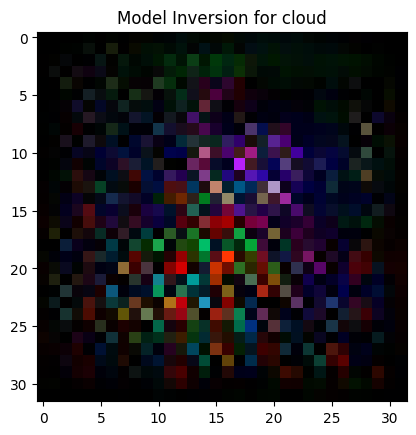

In [228]:
plt.imshow(inverted_inp.permute(1, 2, 0).cpu().detach().numpy())
plt.title(f"Model Inversion for {fine_labels[target_class]}")

# –––––––––––

Text(0.5, 1.0, 'Starting Noise Input')

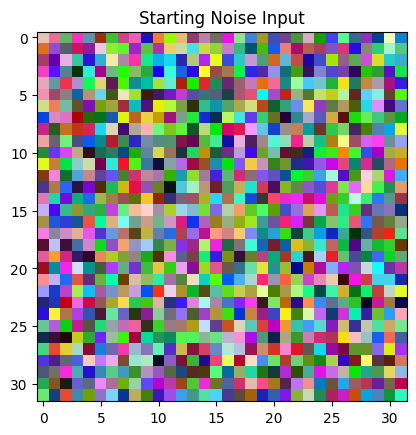

In [382]:
## archived

# compare to starting noise
plt.imshow(inp[0].permute(1, 2, 0).cpu().detach().numpy())
plt.title(f"Starting Noise Input")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Model Inversion for cloud')

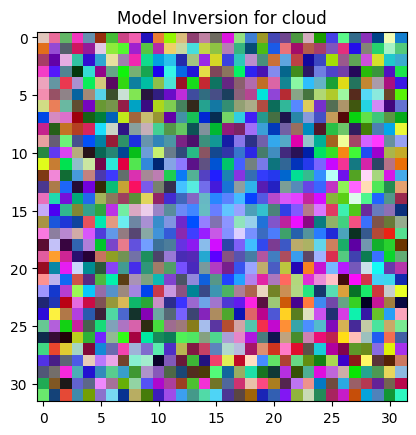

In [381]:
## archived

plt.imshow(inverted_inp.permute(1, 2, 0).cpu().detach().numpy())
plt.title(f"Model Inversion for {fine_labels[target_class]}")

In [112]:
def invert_many(
    model,
    target_class,
    device,
    num_inversions=4,
    lr=1e-2,
    num_iters=10000,
    shape=(1, 3, 32, 32),
):

    images = []
    for i in range(num_inversions):

        print(f"Inversion {i+1}/{num_inversions}")
        inp = torch.rand(shape).to(device)
        inp.requires_grad = True

        img = invert(
            model, inp, target_class, num_iters=num_iters, lr=lr, device=device
        )
        images.append(img)

    images = torch.stack(images)
    plt.imshow(torchvision.utils.make_grid(images.cpu(), nrow=4).permute(1, 2, 0))
    return images

In [ ]:
imgs = invert_many(
    model,
    target_class,
    device=device,
    num_inversions=4,
    lr=1e-2,
    num_iters=10000,
    shape=(1, 3, 32, 32),
)

Inversion 1/4
Inversion 2/4
Inversion 3/4
Inversion 4/4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


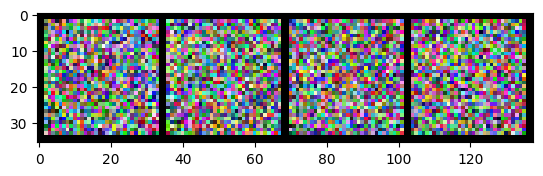

In [113]:
imgs = invert_many(
    model,
    target_class,
    device=device,
    num_inversions=4,
    lr=1e-2,
    num_iters=10000,
    shape=(1, 3, 32, 32),
)

### TODO: test MIA on trained and unlearned model